In [119]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import statsmodels.api as sm

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline
plt.style.use('seaborn')

C:\Users\mureev\AppData\Local\Temp\ipykernel_14764\1772234542.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# **0. Описание задачи**

- Необходимо решить задачу классификации предполагающую построение модели которая предсказывает биологическую активность молекулы по ее составу и свойствам. 
- Столбец "Активность" содержит данные о наличии или отсутсвии биологического ответа. Характеристики молекулы представлены в соответсвующих столбцах **дескрипторах**  
- Предварительная обработка не требуется, данные уже закодированы и нормализованы.
- Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.
- В качестве метрики будем использовать F1-score.

# **1. Знакомство с данными и их исследование**

In [120]:
data = pd.read_csv(r'C:\Users\mureev\Dropbox\SKILLFACTORY\IDE\Py_ML_7\data\_train_sem09.csv')
display(data.head())
data.shape

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


(3751, 1777)

In [121]:
data.iloc[:, 1:10].columns.tolist()

['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']

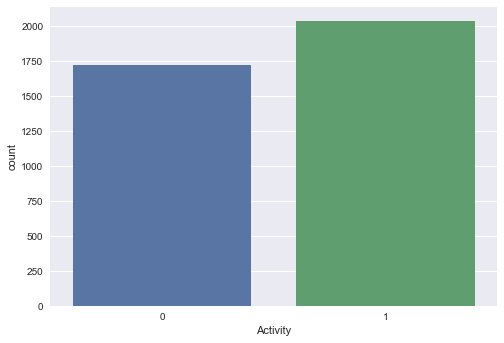

In [122]:
sns.countplot(data=data, x='Activity');

In [123]:
#fig, axes = plt.subplots(9, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#col_list = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']
#for i, feature in enumerate(col_list):
    #sns.histplot(data[feature], ax=axes[i][0])
    #sns.histplot(np.log(data[feature]+1), ax=axes[i][1])
#plt.tight_layout()

# **2. Подготовка данных для моделирования**

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [124]:
X = data.drop('Activity', axis=1)
y = data.Activity
display(data.shape)
display(X.shape)
display(y.shape)

(3751, 1777)

(3751, 1776)

(3751,)

**Избавляемся от мультиколлинеарности**

In [125]:
# Находим столбцы с высокой корреляцией.
data_corr = X.corr()
#display(data_corr)
multi_features = []
m = 0
for i in data_corr.index.tolist():
    for n in data_corr.columns.tolist():
        #print(i, n)
        if (data_corr.loc[i,n] > 0.8) and (data_corr.loc[i,n] != 1):
            multi_features.append([i,n])
            m += 1
# выводим кол-во высокоскоррелированных столбцов
print(m)

980


In [126]:
# удаляем дупликаты
for i in multi_features:
    for m in multi_features:
        if i[0] == m[1] and i[1] == m[0]:
            multi_features.remove(m)
len(multi_features)

490

In [127]:
# создаем таблицу из пар высокоскоррелированных столбцов
multi_df = pd.DataFrame(multi_features, columns=['col0','col1'])

# находим наиболее столбцы встречающиеся с высокой частотой 
seria_0 = multi_df['col0'].value_counts()
mask_0 = multi_df['col0'].value_counts() > 2

seria_1 = multi_df['col1'].value_counts()
mask_1 = multi_df['col1'].value_counts() > 2

# формируем список из уникальных столбцов предназначенных для удаления
cols_to_remove = set(multi_df['col0'].value_counts()[mask_0].index.tolist() + multi_df['col1'].value_counts()[mask_1].index.tolist())
cols_to_remove = list(cols_to_remove)



In [128]:
# удаляем столбцы (из списка) из матрицы наблюдений 
display(X.shape)
X_clean1 = X.drop(cols_to_remove, axis=1)
X_clean1.shape

(3751, 1776)

(3751, 1722)

**Визуализируем важность признаков**

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_clean1, y, stratify=y, random_state = 1, test_size = 0.2)

In [130]:
rf_clf = ensemble.RandomForestClassifier(
   n_estimators=300, #число деревьев
   criterion='entropy', #критерий эффективности
   max_depth=6, #максимальная глубина дерева
   max_features='sqrt', #число признаков из метода случайных подпространств
   random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=300,
                       random_state=42)

(0.0, 0.01)

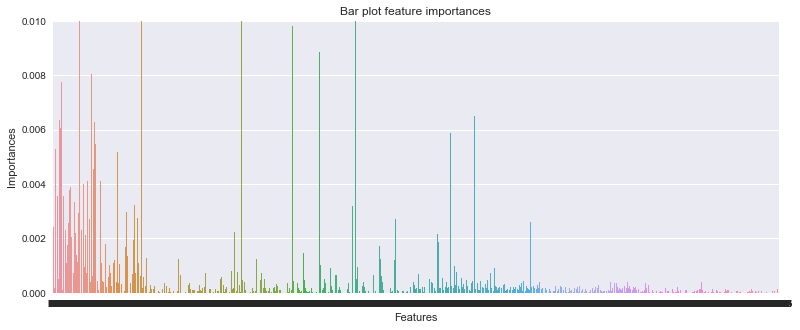

In [131]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_train.columns #признаки
feature_importances = rf_clf.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances')
plt.ylim([0, 0.01])

In [132]:
feature_importance_df = pd.DataFrame({'feature':feature, 'importance':feature_importances})
feature_importance_df.head()

,feature,importance
0,D1,0.002413
1,D2,0.006891
2,D3,0.004171
3,D4,0.000177
4,D5,0.005530


Установим порог важности выше 0.0005

In [133]:
features_to_keep = feature_importance_df[feature_importance_df.importance > 0.0005]['feature'].tolist()
len(features_to_keep)

301

Оставляем только наиболее важные признаки в датасетах X_train и X_test 

In [134]:
X_train = X_train[features_to_keep]
X_test = X_test[features_to_keep]
display(X_train.shape)
display(X_test.shape)

(3000, 301)

(751, 301)

# **3. Моделирование и оптимизация гиперпараметров**

### **A. Logistic Regression**

In [135]:
from sklearn import linear_model #линейные модели

**1A. Baseline model**

Получаем метрики по **базовой модели** логистической регрессии:

In [136]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression()
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print("accuracy на тестовом наборе: {:.2f}".format(metrics.accuracy_score(y_test, y_test_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.77
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79


c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**2A. Hyperparameter Optimization**

***2A-1. GridSearchCV***

Выбираем гиперпараметры подходящие для таблицы и совместимые друг с другом:
- в случае больших таблиц лучше использовать solver = ['sag', 'saga']
- параметры регуляризации совместимые с параметром solver: 
'sag' - ['l2', None]; 'saga' - ['elasticnet','l1','l2',None]
- коэффициент регуляризации C = [0.1, 0.3, 0.5, 0.7, 0.9]
- будем использовать кросс-валидацию с кол-вом фолдов 5: cv=5

In [114]:
# for storage - to be removed
#param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
              ]

IndentationError: unexpected indent (641141888.py, line 3)

In [137]:
from sklearn.model_selection import GridSearchCV
# сетка гиперпараметров
param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['sag', 'saga'], #алгоритм оптимизации
              'C': [0.1, 0.3, 0.5, 0.7, 0.9]
              }

In [138]:
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
# Созданный нами объект grid_search аналогичен классификатору, 
# поэтому мы можем вызвать стандартные методы fit, predict и score от его имени. 
# Однако, когда мы вызываем fit(), он запускает кросс-валидацию для каждой комбинации гиперпараметров, указанных в param_grid:

%time 
grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
# выводим подобранные оптимальные парметры модели
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))
# выводим наиболее оптимальные значения гиперпараметров
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))


CPU times: total: 0 ns
Wall time: 0 ns
accuracy на тестовом наборе: 0.76
Наилучшая модель:
LogisticRegression(C=0.9, max_iter=1000, random_state=42, solver='sag')
Наилучшие значения гиперпараметров: {'C': 0.9, 'penalty': 'l2', 'solver': 'sag'}


In [139]:
# выводим метрики на тестовой выборке
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.79


***2A-2. Randomized Search***

In [140]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {'penalty': ['l2', 'none'],
              'solver': ['saga', 'sag'],
               'C': list(np.linspace(0.1, 1, 10, dtype=float))
               }

In [141]:
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
# выводим подобранные оптимальные парметры модели
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))
# выводим наилучшие параметры
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 5.22 s
Wall time: 1min 48s
accuracy на тестовом наборе: 0.77
Наилучшая модель:
LogisticRegression(C=0.9, max_iter=1000, random_state=42, solver='sag')
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l2', 'C': 0.8}


In [142]:
# выводим метрики на тестовой выборке
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.79


***2A-3. HyperOpt***

In [179]:
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

In [236]:
# сетка гиперпараметров для модели на основе логистической регрессии
space ={
    'penalty' : hp.choice('penalty', ['l2', 'none']), # тип регуляризации
    'solver' : hp.choice('solver', ['sag', 'saga']), # алгоритм оптимизации
    'C' : hp.uniform('C', 0.05, 3)
    } # уровень силы регурялизации

In [237]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
random_state = 42

def hyperopt_lr(params, cv = 5, X = X_train, y = y_train, random_state = random_state):
    params = {
    'penalty' : str(params['penalty']), # тип регуляризации
    'solver' : str(params['solver']), # алгоритм оптимизации
    'C' : int(params['C'])
    }
    
    model = linear_model.LogisticRegression(**params, random_state = random_state)
    
    
    #model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    
    return -score

In [238]:
%%time

trials = Trials()

best = fmin(hyperopt_lr, #наша функция
    space = space, #Пространство параметров
    max_evals= 50, #Количество итераций
    trials = trials,# логирование результатов
    rstate = np.random.default_rng(random_state)
)

print('Наилучшие параметры {}'.format(best))

TPE is being used as the default algorithm.


  4%|▍         | 2/50 [00:02<01:06,  1.39s/trial, best loss: -0.7876041836639043]

job exception: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1233, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\mureev\AppData\Local\Programs\Python\Py

  4%|▍         | 2/50 [00:03<01:14,  1.56s/trial, best loss: -0.7876041836639043]


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1233, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\_parallel_backends.py", line 597, in __init__
    self.results = batch()
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\fixes.py", line 117, in __call__
    return self.function(*args, **kwargs)
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 489, in _logistic_regression_path
    alpha = 1.0 / C
ZeroDivisionError: float division by zero


In [215]:
# выводим метрики для подобранных оптимальных параметров
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    penalty='l2',
    solver='saga',
    C = best['C'],
    random_state = random_state)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

# выводим f1-метрику для тренировочной выборки
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

# рассчитываем accuracy score для тестовой выборки
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))

# выводим f1-метрику для тестовой выборке
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got 1.

***2A-4. Optuna***

In [239]:
# Устанавливаем библиотеку
# !pip install optuna

import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.0.4


In [242]:
random_state = 42
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l2', None])
  solver = trial.suggest_categorical('solver', ['sag', 'saga'])
  C = trial.suggest_int('C', 0.1, 1, 10)

  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty, 
                                          solver=solver, 
                                          C=C, 
                                          random_state = random_state)
  
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [243]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-12-25 03:24:21,915] A new study created in memory with name: LogisticRegression
[W 2022-12-25 03:24:21,933] Trial 0 failed because of the following error: ZeroDivisionError('float division by zero')
Traceback (most recent call last):
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\mureev\AppData\Local\Temp\ipykernel_14764\1660244900.py", line 15, in optuna_rf
    model.fit(X_train, y_train)
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1233, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\mureev\AppData\Local\Programs\Python\Python310\lib\site

ZeroDivisionError: float division by zero

In [ ]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

In [ ]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

### **B. Random Forest**

In [ ]:
from sklearn import ensemble #ансамбли

**1B. Baseline model**

Получаем метрики по **базовой модели** для случайного леса:

In [ ]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)

# f1-score on train dataset
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

# f1-score on a test dataset
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

**2B. Hyperparameter Optimization**
Теперь зададим сетку гиперпараметров: 

*  'n_estimators' - количество деревьев в лесу, по умолчанию =100;
*  'min_samples_leaf' - минимальное количество объектов в листе;
*  'max_depth': максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;


***2B-1. GridSearch CV***

In [ ]:
param_grid = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': list(np.linspace(10, 25, 5, dtype=int))
              }

In [ ]:
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)

# display optimal parameters
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

# f1-score on a train dataset
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

# accuracy on a test dataset
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test, y_test)))

# f1-score on a test dataset.
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

***2B-2. RandomizedSearch***

In [ ]:
param_distributions = {'n_estimators': list(range(80, 200, 20)),
              'min_samples_leaf': [5, 7],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }

In [ ]:
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)

# display optimal parameters
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

# f1-score on train dataset
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

# accuracy on test dataset
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))

# f1-score on a test dataset
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


***2B-3. HyperOpt***

In [ ]:
# сетка гиперпараметров для модели на основе случайного леса
space_rf={'n_estimators': hp.quniform('n_estimators', 80, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [ ]:
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [ ]:
# начинаем подбор гиперпараметров.
%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

In [ ]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
# f1 score on a test dataset
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
# accuracy score on a train dataset
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))

# f1-score on a test dataset
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

***2-4. Optuna***

In [ ]:
import optuna
print("Версия Optuna: {}".format(optuna.__version__))

In [ ]:
random_state = 42
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [ ]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

In [ ]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

In [ ]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

# accuracy score on a train dataset
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))

# f1-score on a test dataset
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))